In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import gepard as g # NeuralModel with Dispersion relation added 
from gepard import model, fitter, data, plots, bmk, dvcs
import gepard.plots as gplot
from gepard import constants
from gepard.fits import GLO15new, AUTIpts, ALUIpts, ACpts, AULpts, ALLpts
print('Gepard version = {}'.format(g.__version__))

Gepard version = 0.9.11b0


In [3]:
import torch
import torch.nn as nn
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path

In [4]:
# To have nice LaTeX fonts on plots
plt.rc('text', usetex=True)
params = {'text.latex.preamble' : '\n'.join([r'\usepackage{amssymb}', r'\usepackage{amsmath}'])}
plt.rcParams.update(params)

### NonDR model

In [5]:
class NNTest(g.model.NeuralModel, g.eff.DipoleEFF, g.dvcs.BM10):    

    def build_net(self):
            '''Overriding the default architecture and optimizer'''
            nn_model = torch.nn.Sequential(
                    torch.nn.Linear(2, 23),
                    torch.nn.ReLU(),
                    torch.nn.Linear(23, 37),
                    torch.nn.ReLU(),
                    torch.nn.Linear(37, 19),
                    torch.nn.ReLU(),
                    torch.nn.Linear(19, len(self.output_layer))
                )
            optimizer = torch.optim.Rprop(nn_model.parameters(), lr=0.001 ) #lr=0.05 #2e-3
            return nn_model, optimizer

### DR model

In [6]:
import torch.nn as nn
class CustomNetwork(nn.Module):
    def __init__(self):
        super(CustomNetwork, self).__init__()

        # Define the layers for the network
        self.n1 = nn.Linear(2, 20)  # 2 input features, 12 hidden units
        self.n2 = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3 = nn.Linear(25, 1)  # 7 hidden units, 1 output features
        
        self.n1p = nn.Linear(1, 20)  # 2 input features, 12 hidden units
        self.n2p = nn.Linear(20, 25)  # 12 hidden units, 17 hidden units
        self.n3p = nn.Linear(25, 1)  # 17 hidden units, 1 output features

    def forward(self, x):
        
       
        x0 = x
        
        # Build Im network
        x = torch.relu(self.n1(x0))
        x = torch.relu(self.n2(x))
        output1 = self.n3(x)
        
        # Build D network
        # build the input tensor
        x0_1 = torch.cat((x0[:,1].unsqueeze(1),), dim=0)
       
        x2 = torch.relu(self.n1p(x0_1))
        x2 = torch.relu(self.n2p(x2))
        output2 = self.n3p(x2)
        
        #concatenate outputs
        output = torch.cat((output1, output2), dim=1)
       
        return output 

In [7]:
class NNTest_DR(g.model.NeuralModel_DR, g.eff.DipoleEFF, g.dvcs.BM10, g.cff.DispersionCFF):
    
    def build_net(self):
        '''Overriding the default architecture and optimizer'''
        nn_model = CustomNetwork()
        optimizer = torch.optim.Rprop(nn_model.parameters(),
                lr=0.01)
        return nn_model, optimizer
    
    def subtraction(self, pt): #This should use the NN, the real part will be calculated by the CFF_Dispersion methods
        """Subtraction constant."""
        xi = pt.xB / (2 - pt.xB)
        #refer to the location of D in output layer (defined in the next cell)
        return self.cffs(2, pt, xi)
    
    def ImH(self, pt, xi=0) -> float:
        """Return Im(CFF H) for kinematic point."""
        #refer to the location of Im H in output layer (defined in the next cell)
        """Return Im(CFF H). If xi is None, infer from pt.xB."""
        #if xi is None:
        #    xi = pt.xB / (2 - pt.xB)
        return self.cffs(0, pt, xi)
    
    def ImE(self, pt, xi=0):
        """Return Im(CFF E) for kinematic point."""
        return self.cffs(1, pt, xi)
    
    def ImHt(self, pt, xi=0):
        """Return Im(CFF Ht) for kinematic point."""
        return self.zero(pt)
    
    def ImEt(self, pt, xi=0):
        """Return Im(CFF Et) for kinematic point."""
        return self.zero(pt)

### Plots

In [14]:
# ---- Define CombinedGoodNets for both DR and NoDR ----

class CombinedGoodNets_NoDR(NNTest):
    def __init__(self, all_nets, selected_indices, output_layer, device='cpu'):
        super().__init__(output_layer=output_layer)
        self.device = device
        self.nets = [all_nets[i] for i in selected_indices]
        self.name = "NoDR Ensemble - Best Nets"

    def predict(self, pt, uncertainty=False, orig_conventions=False, mesh=False, **kwargs):
        inputs = torch.tensor([[pt.xB, pt.t]], dtype=torch.float32).to(self.device)

        all_cff_preds = []
        for net, mean, std in self.nets:
            net = net.to(self.device)
            net.eval()
            x_standardized = (inputs - mean) / (std + 1e-7)
            cff_pred = net(x_standardized)[0].cpu().detach().numpy()
            all_cff_preds.append(cff_pred)

        all_cff_preds = np.stack(all_cff_preds)
        idx = self.cffs_map[pt.observable]

        if mesh:
            return all_cff_preds[:, idx]
        mean_pred = np.mean(all_cff_preds[:, idx])
        std_pred = np.std(all_cff_preds[:, idx])

        if uncertainty:
            return mean_pred, std_pred, std_pred
        else:
            return mean_pred


class CombinedGoodNets_DR(NNTest_DR):
    def __init__(self, all_nets, selected_indices, output_layer, device='cpu'):
        super().__init__(output_layer=output_layer)
        self.device = device
        self.nets = [all_nets[i] for i in selected_indices]
        self.name = "DR Ensemble - Best Nets"

    def predict(self, pt, uncertainty=False, orig_conventions=False, mesh=False, **kwargs):
        if 'observable' in kwargs:
            obs = kwargs['observable']
        else:
            obs = pt.observable

        res = []
        for net in self.nets:
            self.nn_model, self.nn_mean, self.nn_std = net
            self.cffs_evaluated = False
            val = getattr(self, obs)(pt)
            res.append(float(val))

        res = np.array(res)

        if mesh:
            return res
        else:
            mean = res.mean()
            std = res.std()
            return (mean, std, std) if uncertainty else mean



# ---- Fit specs ----
# DR and non-DR paths
fits_to_compare = {
    "CLAS+HERMES (NoDR)": {
        "path": Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/NoDR4CFF_CLAS+HERMES"),
        "filename": "th_combined_goodnets.pt",
        "wrapper_class": CombinedGoodNets_NoDR
    },
    #"CLAS (with DR)": {
    #    "path": Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/DR4CFF_CLAS"),
    #    "filename": "th_combined_goodnets.pt",
    #    "wrapper_class": CombinedGoodNets_DR
    #},
    "CLAS+HERMES (with DR)": {
        "path": Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/DR4CFF_CLAS+HERMES_v2"),
        "filename": "th_combined_goodnets.pt",
        "wrapper_class": CombinedGoodNets_DR
    }
    #,"CLAS+HERMES+HALLA (with DR)": {
    #    "path": Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/DR4CFF_CLAS+HERMES+HALLA"),
    #    "filename": "th_combined_full.pt",
    #    "wrapper_class": CombinedGoodNets_DR
    #}
}


loaded_models = {}

for label, info in fits_to_compare.items():
    fit_file = info["path"] / info["filename"]
    checkpoint = torch.load(fit_file, map_location='cpu')

    wrapper = info["wrapper_class"](
        all_nets=checkpoint['nets'],
        selected_indices=list(range(len(checkpoint['nets']))),
        output_layer=checkpoint['output_layer']
    )
    wrapper.name = label
    loaded_models[label] = wrapper

print(f"✅ Loaded {len(loaded_models)} models for comparison.")

✅ Loaded 2 models for comparison.


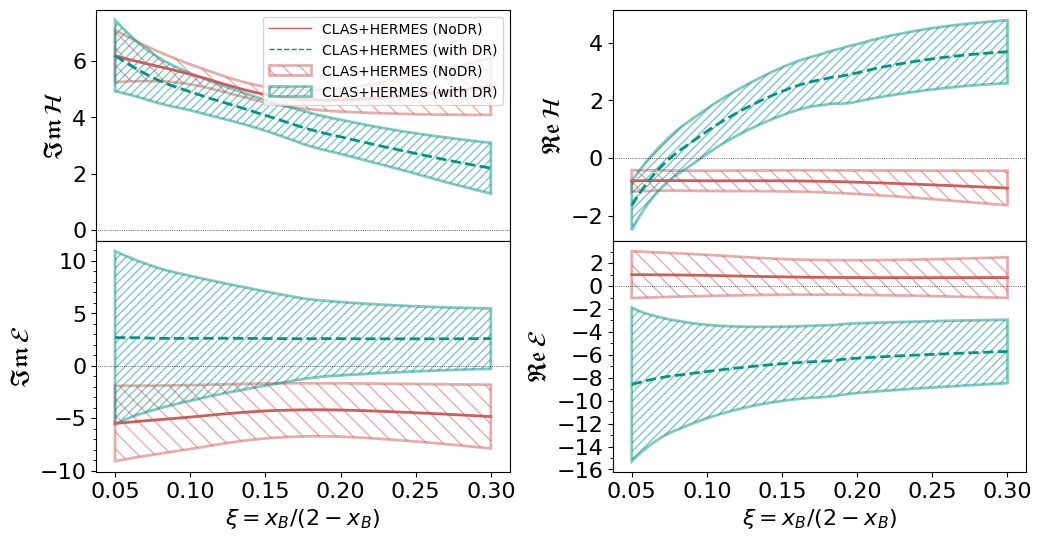

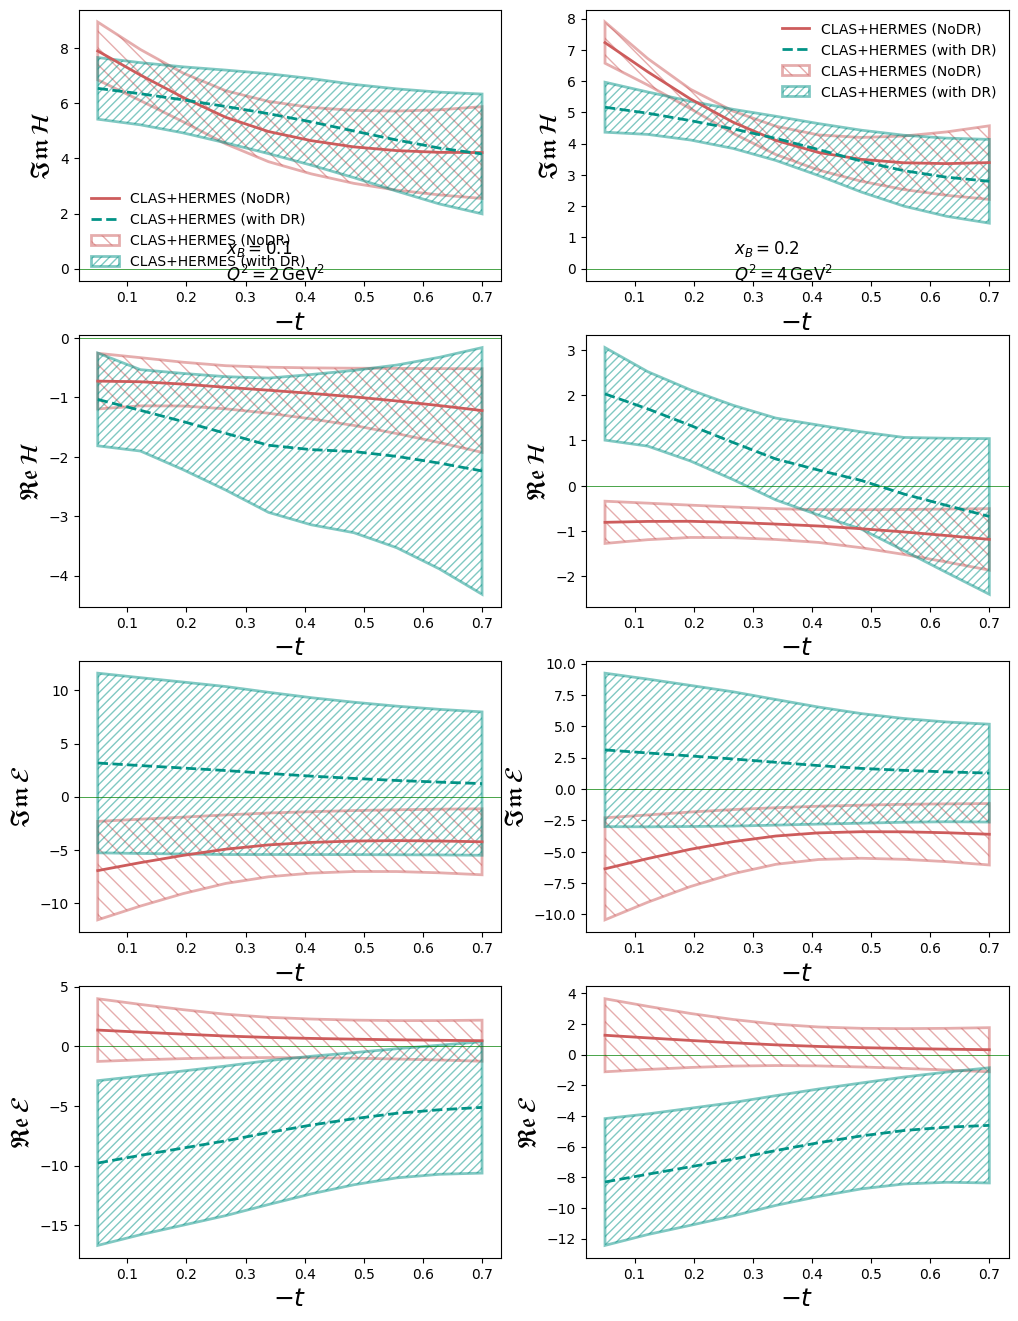

In [17]:
plt.rcParams['text.usetex'] = False

output_cffs = ['ImH', 'ReH', 'ImE', 'ReE']
comparison_dir = Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/Results/Comparison_CFFs")
comparison_dir.mkdir(parents=True, exist_ok=True)

# CFF3 (linear)
fig = gplot.CFF3(
    cffs=output_cffs,
    lines=list(loaded_models.values()),
    bands=list(loaded_models.values())
)
plt.show()
fig.savefig(comparison_dir / "CFF3_CLAS+HERMES_DRvsNoDR_comparison.png")

# CFFt (-t)
fig = gplot.CFFt(
    cffs=output_cffs,
    lines=list(loaded_models.values()),
    bands=list(loaded_models.values())
)
plt.show()
fig.savefig(comparison_dir / "CFFt_CLAS+HERMES_DRvsNoDR_comparison.png")


In [16]:
''' class CombinedGoodNets(NNTest):
    def __init__(self, all_nets, selected_indices, output_layer, device='cpu'):
        super().__init__(output_layer=output_layer)
        self.device = device
        self.nets = [all_nets[i] for i in selected_indices]
        self.name = "NoDR Ensemble - Best Nets"

    def predict(self, pt, uncertainty=False, orig_conventions=False, mesh=False, **kwargs):
        inputs = torch.tensor([[pt.xB, pt.t]], dtype=torch.float32).to(self.device)

        all_cff_preds = []
        for net, mean, std in self.nets:
            net = net.to(self.device)
            net.eval()
            x_standardized = (inputs - mean) / (std + 1e-7)
            cff_pred = net(x_standardized)[0].cpu().detach().numpy()
            all_cff_preds.append(cff_pred)

        all_cff_preds = np.stack(all_cff_preds)
        idx = self.cffs_map[pt.observable]

        if mesh:
            return all_cff_preds[:, idx]

        mean_pred = np.mean(all_cff_preds[:, idx])
        std_pred = np.std(all_cff_preds[:, idx])

        if uncertainty:
            return mean_pred, std_pred, std_pred
        else:
            return mean_pred '''

' class CombinedGoodNets(NNTest):\n    def __init__(self, all_nets, selected_indices, output_layer, device=\'cpu\'):\n        super().__init__(output_layer=output_layer)\n        self.device = device\n        self.nets = [all_nets[i] for i in selected_indices]\n        self.name = "NoDR Ensemble - Best Nets"\n\n    def predict(self, pt, uncertainty=False, orig_conventions=False, mesh=False, **kwargs):\n        inputs = torch.tensor([[pt.xB, pt.t]], dtype=torch.float32).to(self.device)\n\n        all_cff_preds = []\n        for net, mean, std in self.nets:\n            net = net.to(self.device)\n            net.eval()\n            x_standardized = (inputs - mean) / (std + 1e-7)\n            cff_pred = net(x_standardized)[0].cpu().detach().numpy()\n            all_cff_preds.append(cff_pred)\n\n        all_cff_preds = np.stack(all_cff_preds)\n        idx = self.cffs_map[pt.observable]\n\n        if mesh:\n            return all_cff_preds[:, idx]\n\n        mean_pred = np.mean(all_cff_pred

In [ ]:
# Configuration for different fits
''' fits_to_compare = {
    "CLAS 6GeV": {
        "path": Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test1"),
        "filename": "th_combined_goodnets.pt"
    },
    "CLAS 6+11GeV": {
        "path": Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/Test2"),
        "filename": "th_combined_goodnets.pt"
    },
    #"CLAS With DR": {
    #    "path": Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/fits_models/DR4CFF_CLAS"),
    #    "filename": "th_combined_goodnets.pt"
    #}
} '''

In [ ]:
'''loaded_models = {}

for label, info in fits_to_compare.items():
    fit_file = info["path"] / info["filename"]
    checkpoint = torch.load(fit_file, map_location='cpu')

    model = CombinedGoodNets(
        all_nets=checkpoint['nets'],
        selected_indices=list(range(len(checkpoint['nets']))),
        output_layer=checkpoint['output_layer']
    )
    model.name = label

    loaded_models[label] = model

print(f"✅ Loaded {len(loaded_models)} fits for comparison.")'''

✅ Loaded 2 fits for comparison.


In [ ]:
# Create directory
'''comparison_dir = Path("/Users/higuera-admin/Documents/Programs/ldrdgff/Analysis/tests/Results/Comparison_CFFs")
comparison_dir.mkdir(parents=True, exist_ok=True)'''

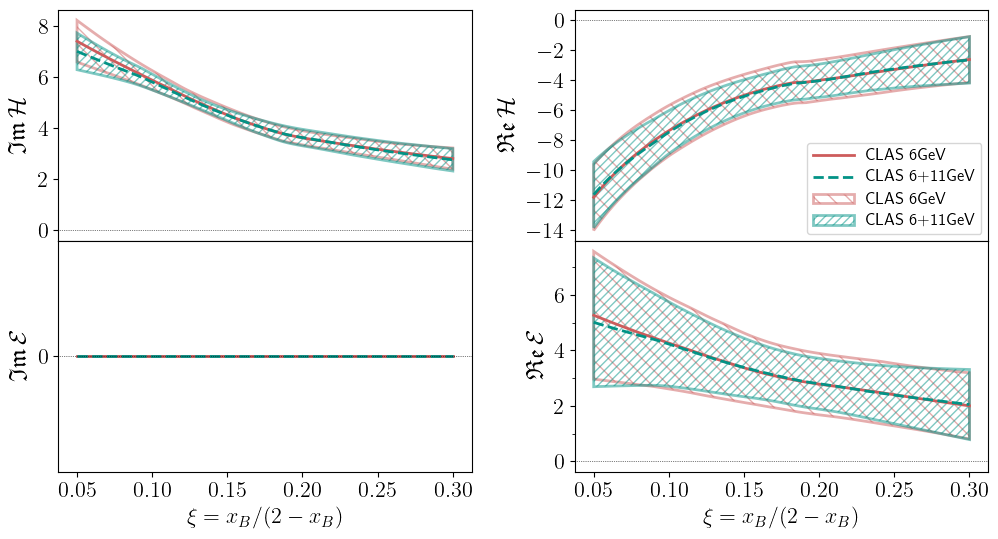

✅ Saved CFF3 plot.


In [ ]:
# --- 4. Plot CFF3 (linear) ---
'''
fig = gplot.CFF3(
    cffs=['ImH', 'ReH', 'ImE', 'ReE'],
    lines=list(loaded_models.values()),
    bands=list(loaded_models.values())
)
# plt.title("CFF3 Comparison (linear)")  # Add a title if you want
# plt.legend(loc='best', fontsize=12)  
# plt.tight_layout()
plt.show() 
#fig.savefig(comparison_dir / "CFF3_CLA+HER+TSAclas.png")
print(f"✅ Saved CFF3 plot.")'''

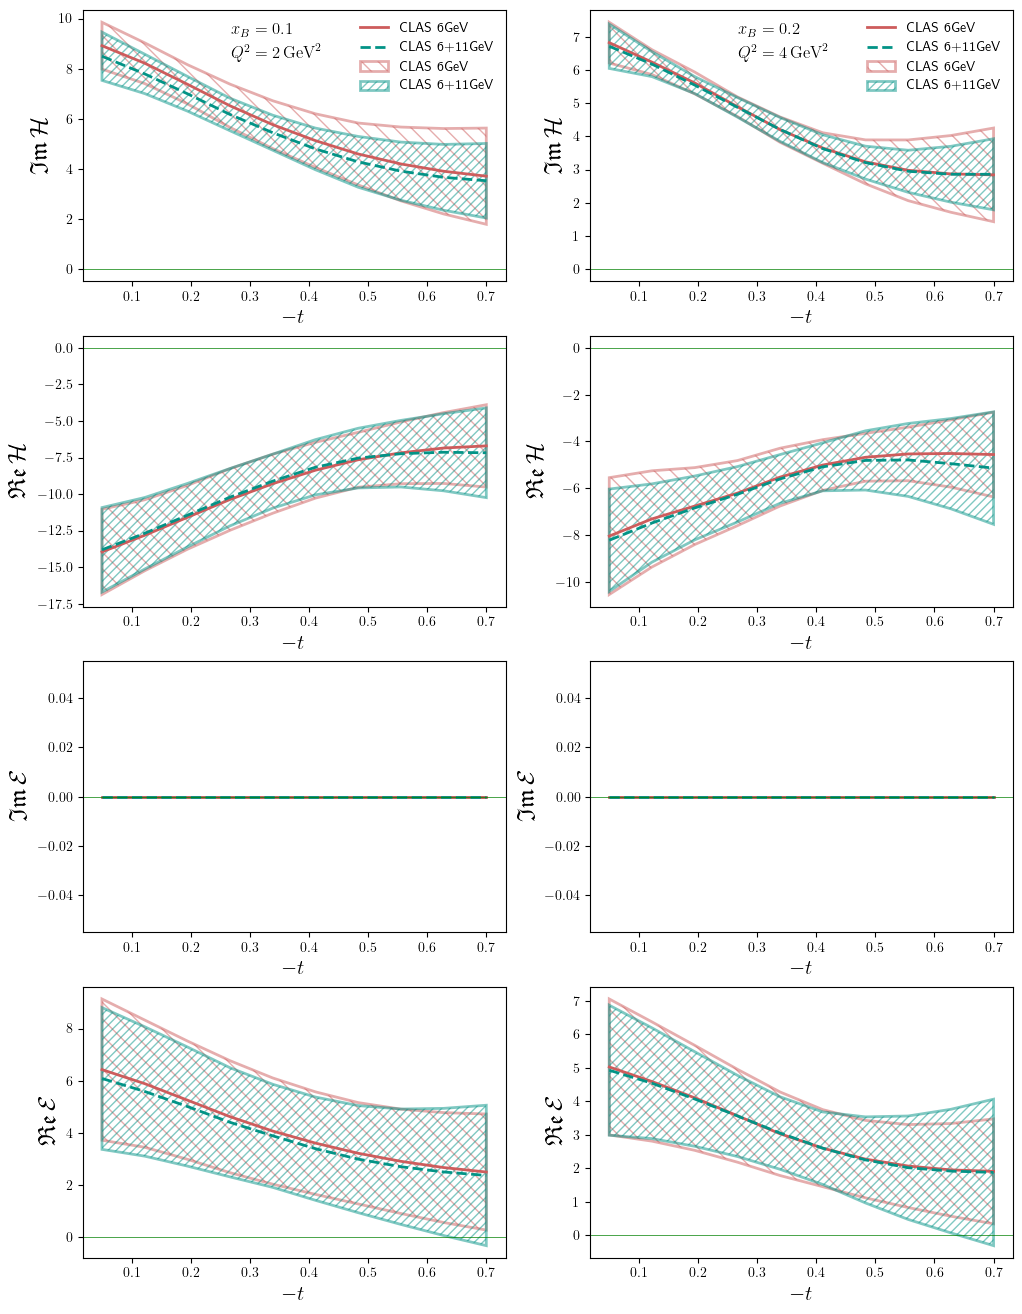

✅ Saved CFFt plot.


In [ ]:
# --- 5. Plot CFFt (vs -t) ---
'''
fig = gplot.CFFt(
    cffs=['ImH', 'ReH', 'ImE', 'ReE'],
    lines=list(loaded_models.values()),
    bands=list(loaded_models.values())
)
# plt.title("CFFt Comparison (vs t)")  
# plt.legend(loc='best', fontsize=12)  
# plt.tight_layout()
plt.show() 
#fig.savefig(comparison_dir / "CFFt_CLA+HER+TSAclas.png")
print(f"✅ Saved CFFt plot.")'''